<a href="https://colab.research.google.com/github/SanjanaTikare117/Deep-Learning-Binary-Classification-using-Bank-Churn/blob/main/BINARY_CLASSIFICATION_WITH_BANK_CHURN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F65711%2F7405009%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240211%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240211T173806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D31f69955a0af2d8ab17708608b46e6ee78682cf8e002693397aec0c05172e1b8afd7f4db437e4d47b545918a9fed10f59682e257d07072ac8eddb0d4164c57ec69b70a45e13b6c10b06ee36688e8c48f67666a4a5da88465aac0454411e2de695a5e8f63adbf1eb214704e57ea63781c0c1a2f1871738924e6836b255d8d75ef4056949f4cab82dd390e99b9963f58c97a1355612dc08ef88c720f06a082bd8edb94e0a3d4934aa4919eca2b768d2889810a001a25d861aa8d3b165da438001fe612e405d4fd4a60629ea0cd391a8b8193eb43f4907fcf7f7809a1abcb790fc85de78115707c602397b3e7d321ab8fcc257c4dd59e5a7bf9e445fbb412e484ee'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df.drop(['id', 'CustomerId', 'Surname'], inplace=True, axis=1)

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
df['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [ ]:
df_geo = pd.get_dummies(df['Geography']).astype(int)

df = pd.concat([df, df_geo.iloc[:, 0:2]], axis=1)
df.drop('Geography', axis=1, inplace=True)

In [ ]:
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

df['Age'] = df['Age'].astype(int)
df['HasCrCard'] = df['HasCrCard'].astype(int)
df['IsActiveMember'] = df['IsActiveMember'].astype(int)

df

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany
0,668,0,33,3,0.00,2,1,0,181449.97,0,1,0
1,627,0,33,1,0.00,2,1,1,49503.50,0,1,0
2,678,0,40,10,0.00,2,1,0,184866.69,0,1,0
3,581,0,34,2,148882.54,1,1,1,84560.88,0,1,0
4,716,0,33,5,0.00,2,1,1,15068.83,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,1,33,2,0.00,1,1,1,131834.75,0,0,0
165030,792,0,35,3,0.00,1,0,0,131834.45,0,1,0
165031,565,0,31,5,0.00,1,1,1,127429.56,0,1,0
165032,554,1,30,7,161533.00,1,0,1,71173.03,0,0,0


(array([7.0930e+03, 3.6582e+04, 6.9108e+04, 3.0665e+04, 1.2109e+04,
        6.6800e+03, 1.9750e+03, 7.3600e+02, 7.2000e+01, 1.4000e+01]),
 array([18. , 25.4, 32.8, 40.2, 47.6, 55. , 62.4, 69.8, 77.2, 84.6, 92. ]),
 <BarContainer object of 10 artists>)

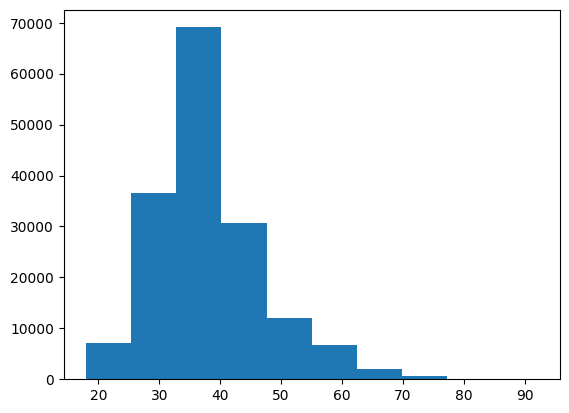

In [ ]:
plt.hist(df['Age'])

PREPARING DATA

In [ ]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=42)

X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany
5127,609,0,34,2,0.00,1,1,1,16250.61,1,0
162903,736,0,35,8,0.00,1,0,1,79082.62,0,0
52185,746,1,38,4,166883.07,1,0,1,194563.65,1,0
39249,567,1,40,5,0.00,2,1,0,126537.07,0,0
115410,631,1,37,6,0.00,3,1,1,125877.22,0,0


In [ ]:
TRAINING OF MODEL

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
clf = LGBMClassifier()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf.fit(X_train_scaled, y_train)

LGBMClassifier()

In [ ]:
from sklearn.metrics import roc_auc_score

y_train_pred = clf.predict_proba(X_train_scaled)[:, 1]
y_test_pred = clf.predict_proba(X_test_scaled)[:, 1]

train_score = roc_auc_score(y_train, y_train_pred)
test_score = roc_auc_score(y_test, y_test_pred)

print('Training score', train_score)
print('Test score', test_score)

Training score 0.8965659669717003
Test score 0.8916663484142543


In [ ]:
TUNING

In [ ]:
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate_log = trial.suggest_float('learning_rate_log', -3, -1)

    clf = LGBMClassifier(class_weight='balanced',
                         max_depth = max_depth,
                         n_estimators = n_estimators,
                         learning_rate = 10**learning_rate_log)

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    cv_results = cross_validate(clf, X_std, y, cv=5, scoring='roc_auc')

    validation_score = np.mean(cv_results['test_score'])

    return validation_score

In [ ]:
best_params = {'max_depth': 5, 'n_estimators': 311, 'learning_rate_log': -1.3626471089871763}

print(best_params)

{'max_depth': 5, 'n_estimators': 311, 'learning_rate_log': -1.3626471089871763}


In [ ]:
PREDICTIONS

In [ ]:
def apply_preprocessing(df2):
    df = df2.copy(deep=True)

    # drop useless features
    df.drop(['id', 'CustomerId', 'Surname'], inplace=True, axis=1)

    # one-hot encoding
    df_geo = pd.get_dummies(df['Geography']).astype(int)
    df = pd.concat([df, df_geo.iloc[:, 0:2]], axis=1)
    df.drop('Geography', axis=1, inplace=True)

    # map male and female
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

    # convert to integer
    df['Age'] = df['Age'].astype(int)
    df['HasCrCard'] = df['HasCrCard'].astype(int)
    df['IsActiveMember'] = df['IsActiveMember'].astype(int)

    cnames = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'France',
       'Germany']

    df = df.loc[:, cnames]

    return df

In [ ]:
TRAIN THE MODEL

In [ ]:

clf = LGBMClassifier(class_weight='balanced',
                     max_depth = best_params['max_depth'],
                     n_estimators = best_params['n_estimators'],
                     learning_rate = 10**best_params['learning_rate_log'])

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
clf.fit(X_std, y)


LGBMClassifier(class_weight='balanced', learning_rate=0.04338632758271591,
               max_depth=5, n_estimators=311)

In [ ]:
TEST THE DATA

In [ ]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

X_test = apply_preprocessing(df_test)

X_test = X_test.loc[:, X_train.columns]
X_test = scaler.transform(X_test)

In [ ]:
y_test_pred = clf.predict_proba(X_test)[:, 1]

y_test_pred

array([0.11737585, 0.942164  , 0.08111905, ..., 0.06779818, 0.39814029,
       0.44793561])

In [ ]:
df_test['Exited'] = y_test_pred

df_results = df_test[['id', 'Exited']]
df_results.to_csv('submission.csv', index=False)

df_results

,id,Exited
0,165034,0.117376
1,165035,0.942164
2,165036,0.081119
3,165037,0.525132
4,165038,0.661479
...,...,...
110018,275052,0.133590
110019,275053,0.309338
110020,275054,0.067798
110021,275055,0.398140


In [ ]:
df_results['Exited'].mean()

0.36507048702865386